# Imports

In [1]:
# Standard library imports
import math
import os
import random

# Third-party imports
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import timm
import torch
import torchvision
import torchvision.models as models
from torch import Tensor, optim
from torch.nn import TransformerDecoder, TransformerDecoderLayer, utils
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

# Building Vocabulary, Dataloaders, and Datasets

In [2]:
# Tokenizer to split sentences into a list of words
word_tokenizer = spacy.load("en_core_web_sm")

class Vocabulary():
  """
  Class to convert the captions to index sequential tensors

  Args:
    freq_threshold (int, optional): How many times a word has to appear in dataset before it can be added to the vocabulary. Defaults to 2
  """

  def __init__(self, freq_threshold:int=2):
    self.itos={ 0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>" } # index to sentence
    self.stoi={ "<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3 } # sentence to index
    self.freq_threshold = freq_threshold # threshold for adding a word to the vocab

  def __len__(self):
    return len(self.itos)

  @staticmethod
  def tokenizer_eng(text):
    # convert sentence to list of words
    return [tok.text.lower() for tok in word_tokenizer.tokenizer(text)] # convert sentence to words


  def build_vocabulary(self, sentence_list):
    frequencies = {}
    idx = 4 # 0-3 are for special tokens

    for sentence in sentence_list:
      for word in self.tokenizer_eng(sentence): # convert sentence to words
        if word not in frequencies:
          frequencies[word] = 1
        else:
          frequencies[word] += 1

        if frequencies[word] == self.freq_threshold: # once met freq_threshold, add to vocab list
          self.stoi[word] = idx
          self.itos[idx] = word
          idx += 1

  def numericalize(self, text):
    tokenized_text = self.tokenizer_eng(text) # convert annotations to labels by converting each word to the index inside the vocab, else UNK tag
    
    result = []

    for token in tokenized_text:
      if token in self.stoi:
        result.append(self.stoi[token])
      else:
        result.append(self.stoi["<UNK>"])
            
    return result

In [3]:
class CustomDataset(Dataset):
  """
    Class to setup the custom Dataset for pyTorch Dataloader
    
    Args:
      root_dir (str): The directory path where image files are stored.
      caption_file (str): Path to the CSV file containing image file names and corresponding captions.
      transform (callable, optional): A function/transform that takes in an PIL image and returns a transformed version.
      freq_threshold (int, optional): The minimum frequency a word must have to be included in the vocabulary.
      vocabulary (Vocabulary, optional): Determines to use an existing vocabulary or create own, defaults to None
    Returns:
      image: transformed image
      labels: image caption in numerical token form
      all_image_captions: list containing all the captions of the image
  """
  
  def __init__(self, root_dir:list, caption_file:list, transform=None, freq_threshold:int=5, vocabulary=None):
    self.annotations = pd.DataFrame()
    self.root_dir_boundary = []

    for idx, label_files in enumerate(caption_file): 
      labels = pd.read_csv(label_files, index_col=0)
      self.annotations = pd.concat([self.annotations, labels], ignore_index=True) #merging annotations into 1 dataset

      if idx == 0: 
        self.root_dir_boundary.append(len(labels))
      else:
        self.root_dir_boundary.append(self.root_dir_boundary[idx-1] + len(labels))

      self.root_dir = root_dir
      self.transform = transform

      if vocabulary == None:
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.annotations.iloc[:,1].to_list())
      else:
        self.vocab = vocabulary
      
  def __len__(self):
    return len(self.annotations)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = self.annotations.iloc[idx, 0]
    image_dir_idx = 0

    while idx >= self.root_dir_boundary[image_dir_idx] and image_dir_idx < len(self.root_dir_boundary):
      image_dir_idx += 1

    img_path = f"{self.root_dir[image_dir_idx]}/{img_name}"
    image = Image.open(img_path)

    if self.transform is not None:
      image = self.transform(image)
      
    annotation = self.annotations.iloc[idx, 1]
        
    numericalized_caption = [self.vocab.stoi["<SOS>"]]
    numericalized_caption += self.vocab.numericalize(annotation)
    numericalized_caption.append(self.vocab.stoi["<EOS>"])

    all_img_captions = self.annotations[self.annotations['image_filename'] == img_name]
    
    return image, torch.tensor(numericalized_caption), all_img_captions.iloc[:,1].to_list()


In [4]:
class padAnnotations():
  """
    A custom collate function for PyTorch DataLoader to handle batching of images and captions.    
    This collate function is used to dynamically pad the captions in a batch to the same length so that they can be processed as a batch. 

    Args:
      pad_idx (int): The index of the PAD token in the vocabulary, used for padding shorter captions in a batch to match the longest caption.
        
    Returns: 
      img: batch image object
      labels: batch of tensors of the captions, converted to the same length by adding <PAD>
      all_labels: batch of lists of the captions of the images
  """
  
  def __init__(self, pad_idx:int, batch_first:bool=False):
    self.batch_first = batch_first
    self.pad_idx = pad_idx
      
  def __call__(self, batch):
    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs, dim=0)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
    all_labels = [item[2] for item in batch]

    return imgs, targets, all_labels

In [5]:
def get_loader(
  images_path:list,
  captions_path:list,
  transform,
  transform_finetune,
  batch_size:int=32,
  num_workers:int=8,
  shuffle:bool=True,
  pin_memory:bool=True,
  vocabulary=None,
  batch_first:bool=False
):
  dataset = CustomDataset(images_path, captions_path, transform=transform, vocabulary=vocabulary)
  dataset_finetune = CustomDataset(images_path, captions_path, transform=transform_finetune, vocabulary=vocabulary)

  if vocabulary is None:
    vocabulary = dataset.vocab
  
  loader = DataLoader(
    dataset = dataset,
    batch_size = batch_size,
    num_workers = num_workers,
    shuffle = shuffle,
    pin_memory = pin_memory,
    collate_fn = padAnnotations(pad_idx=vocabulary.stoi["<PAD>"], batch_first=batch_first)
  )

  loader_finetune  = DataLoader(
    dataset = dataset_finetune,
    batch_size = batch_size,
    num_workers = num_workers,
    shuffle = shuffle,
    pin_memory = pin_memory,
    collate_fn = padAnnotations(pad_idx=vocabulary.stoi["<PAD>"], batch_first=batch_first)
  )
  
  return loader, loader_finetune, dataset

In [6]:
image_size = (256, 256)
image_size_finetune = (224, 224)
batch_size = 32

# Transforms for image processing in training
train_transform = transforms.Compose([
  transforms.Resize(image_size),
  transforms.TrivialAugmentWide(),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transform_finetune = transforms.Compose([
  transforms.Resize(image_size_finetune),
  transforms.TrivialAugmentWide(),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
  
# Transforms for image processing in validation
eval_transform = transforms.Compose([
  transforms.Resize(image_size),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

eval_transform_finetune = transforms.Compose([
  transforms.Resize(image_size_finetune),
  transforms.TrivialAugmentWide(),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
train_dataloader, train_dataloader_finetune, train_dataset = get_loader(
  images_path=['../input/Landscape/Train/Images', '../input/Landscape/Train/Images', '../input/Flicker8k/Train/Images'],
  captions_path=['../input/Landscape/Train/Labels/Blip_Label_Clean.csv', '../input/Landscape/Train/Labels/Kosmos_Label_Clean.csv', '../input/Flicker8k/Train/Labels/Label.csv'],
  transform=train_transform,
  transform_finetune=train_transform_finetune,
  batch_size=batch_size,
  num_workers=0,
  batch_first=False
)

val_dataloader, val_dataloader_finetune, val_dataset = get_loader(
  images_path=['../input/Landscape/Validation/Images', '../input/Landscape/Validation/Images', '../input/Flicker8k/Validation/Images'],
  captions_path=['../input/Landscape/Validation/Labels/Blip_Label_Clean.csv', '../input/Landscape/Validation/Labels/Kosmos_Label_Clean.csv', '../input/Flicker8k/Validation/Labels/Label.csv'],
  transform=eval_transform,
  transform_finetune=eval_transform_finetune,
  batch_size=batch_size,
  num_workers=0,
  vocabulary=train_dataset.vocab,
  batch_first=False
)

test_dataloader, test_dataloader_finetune, test_dataset = get_loader(
  images_path=['../input/Landscape/Test/Images', '../input/Landscape/Test/Images', '../input/Flicker8k/Test/Images'],
  captions_path=['../input/Landscape/Test/Labels/Blip_Label_Clean.csv', '../input/Landscape/Test/Labels/Kosmos_Label_Clean.csv', '../input/Flicker8k/Test/Labels/Label.csv'],
  transform=eval_transform,
  transform_finetune=eval_transform_finetune,
  batch_size=batch_size,
  num_workers=0,
  vocabulary=train_dataset.vocab,
  batch_first=False
)

trg_vocab = train_dataset.vocab
trg_vocab_size = len(train_dataset.vocab)

# Image Caption Visualization

In [8]:
def visualise_img_caption_data(dataloader, batch_size: int, dataset: CustomDataset, num_batches: int = 1, num_samples: int=9):
    """
    Function to visualise the dataset

    Args:
        dataloader (dataloader object): Pytorch dataloader object to visualise
        batch_size (int): Batch Size of dataloader
        dataset (CustomDataset): dataset used to create dataloader (required to get the vocabulary)
        num_batches (int, optional): How many batches to visualise, defaults to 1
        num_samples (int, optional): How many images per batch to visualise, defaults to 9

    Returns:
        Plot of image with its caption and the list of the captions to the image
    """

    for i in range(num_batches):
        train_features, train_labels, train_all_captions = next(iter(dataloader))
        if i == 0:  # Print shape
            print(f"Feature batch shape: {train_features.size()}")
            print(f"Labels batch shape: {train_labels.size()}")
            print(f"All captions batch size: {len(train_all_captions)}")

        for j in range(num_samples):
            #Prepare image to print
            img = train_features[j].squeeze()
            img = np.transpose(img.numpy(), (1, 2, 0))  #Convert from (channel, height, width) to (height, width, channel) for matplotlib

            #Transpose train_labels and handle out of range indices
            label = train_labels[:, j] if train_labels.size(0) != batch_size else train_labels[0]
            string_label = [dataset.vocab.itos[idx] for idx in label.tolist()]
            actual_caption = " ".join([token for token in string_label if token not in ['<PAD>', '<SOS>', '<EOS>']])

            #Create a new plot for each image
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Caption: {actual_caption}\n\nAll Possible Captions:\n' + "\n".join(train_all_captions[j]), loc='left')

            plt.tight_layout()
            plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([22, 32])
All captions batch size: 32


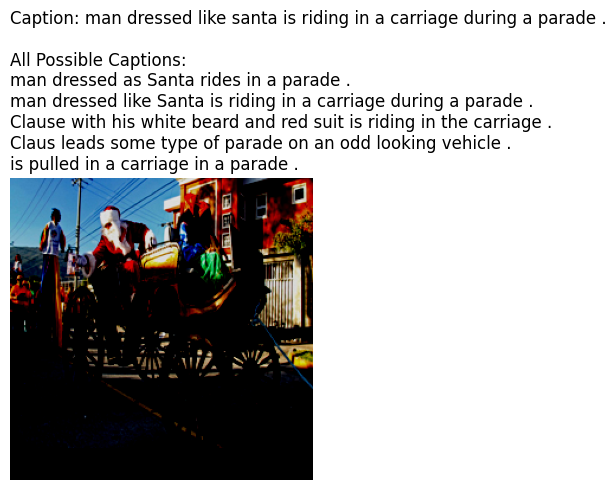

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


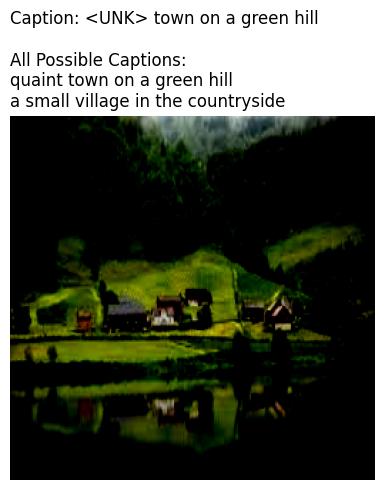

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


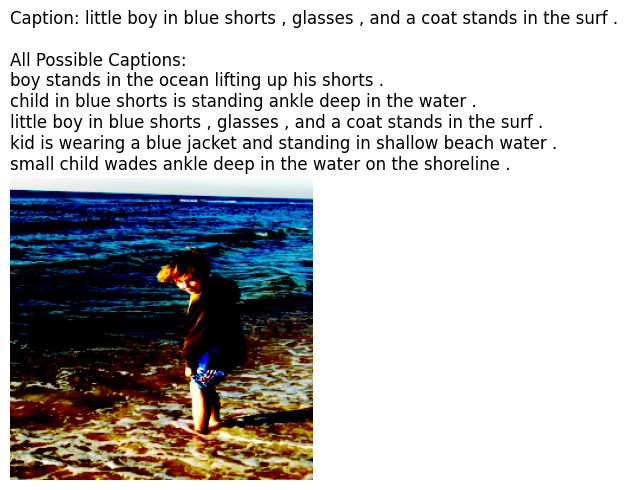

In [9]:
visualise_img_caption_data(train_dataloader, batch_size, train_dataset, num_samples=3)

# Model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
model_used = 'maxvit_rmlp_tiny_rw_256.sw_in1k'
model = timm.create_model(model_used, pretrained=True)
print(model)


MaxxVit(
  (stem): Stem(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (stages): Sequential(
    (0): MaxxVitStage(
      (blocks): Sequential(
        (0): MaxxVitBlock(
          (conv): MbConvBlock(
            (shortcut): Downsample2d(
              (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
              (expand): Identity()
            )
            (pre_norm): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Identity()
            )
            (down): Identity()
            (conv1_1x1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm1

In [12]:
a = torchvision.models.maxvit_t()
for name, param in a.named_parameters():
    print(name)

c:\Users\valkr\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


stem.0.0.weight
stem.0.1.weight
stem.0.1.bias
stem.1.0.weight
stem.1.0.bias
blocks.0.layers.0.layers.MBconv.proj.1.weight
blocks.0.layers.0.layers.MBconv.proj.1.bias
blocks.0.layers.0.layers.MBconv.layers.pre_norm.weight
blocks.0.layers.0.layers.MBconv.layers.pre_norm.bias
blocks.0.layers.0.layers.MBconv.layers.conv_a.0.weight
blocks.0.layers.0.layers.MBconv.layers.conv_a.1.weight
blocks.0.layers.0.layers.MBconv.layers.conv_a.1.bias
blocks.0.layers.0.layers.MBconv.layers.conv_b.0.weight
blocks.0.layers.0.layers.MBconv.layers.conv_b.1.weight
blocks.0.layers.0.layers.MBconv.layers.conv_b.1.bias
blocks.0.layers.0.layers.MBconv.layers.squeeze_excitation.fc1.weight
blocks.0.layers.0.layers.MBconv.layers.squeeze_excitation.fc1.bias
blocks.0.layers.0.layers.MBconv.layers.squeeze_excitation.fc2.weight
blocks.0.layers.0.layers.MBconv.layers.squeeze_excitation.fc2.bias
blocks.0.layers.0.layers.MBconv.layers.conv_c.weight
blocks.0.layers.0.layers.MBconv.layers.conv_c.bias
blocks.0.layers.0.layers

In [13]:
class EncoderMaxVit(nn.Module):
  """
    An encoder module based on the MaxVit architecture, adapted for image captioning by converting images into dense feature embeddings.

    This encoder takes an image as input and processes it through a pre-trained MaxVit model. 
    The final fully connected (fc) layer of the MaxVit model is replaced to map the extracted features to the desired embedding size.

    Args:
      embedding_size (int): The size of the embedding vector for the image features.
      train_CNN (bool, optional): Flag to determine whether the MaxVit model should be fine-tuned. Defaults to False.
      drop_p (float, optional): Dropout probability to use in the dropout layer for regularization. Defaults to 0.5.

    The output feature vector from this encoder is then passed to a decoder to generate captions.
  """
  
  def __init__(self, pretrained_model, embedding_size:int, train_CNN:bool=False, drop_p:float=0.5):
    super(EncoderMaxVit, self).__init__()
    self.embed_size = embedding_size
    self.train_CNN = train_CNN
    self.p=drop_p

    if pretrained_model is not None:
      # Initialize custom finetuned model and make the last linear layer trainable
      self.model = list(pretrained_model.children())[0]
      self.model.classifier[-1] = nn.Linear(in_features=self.model.classifier[-1].in_features, out_features=self.embed_size, bias=True)

      for name, param in self.model.named_parameters():
        if "classifier.5.weight" in name or "classifier.5.bias" in name:
          param.requires_grad = True
        else:
          param.requires_grad = self.train_CNN


    else:
      # Initialize pretrained model and make last linear layer trainable
      model_used = 'maxvit_rmlp_tiny_rw_256.sw_in1k'
      self.model = timm.create_model(model_used, pretrained=True)
      self.model.head.fc = nn.Linear(in_features=self.model.head.fc.in_features, out_features=self.embed_size, bias=True)

      for name , param in self.model.named_parameters():
        if "head.fc.weight" in name or "head.fc.bias" in name:
          param.requires_grad = True
        else:
          param.requires_grad = self.train_CNN

    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(self.p)
    
              
  def forward(self, image):
    output = self.model(image)
    output = self.dropout(self.relu(output))
    
    return output



class PositionalEncoding(nn.Module):
  """
    Injects some information about the relative or absolute position of the tokens in the sequence.
    Embeddings do not encode the relative position of tokens in a sentence. 
    With positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sequence, in the d-dimensional space.

    Args:
      d_model (int): The dimension of the embeddings.
      dropout (float, optional): The dropout value.
      max_len (int, optional): The maximum length of the input sequences.
  """
  
  def __init__(self, d_model: int, dropout: float=0.1, max_len: int=5000):
    super().__init__()

    self.dropout = nn.Dropout(p=dropout)
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x: Tensor) -> Tensor:
    """
      Arguments:
        x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
    """
    x = x + self.pe[:x.size(0)]
    return self.dropout(x)
  


class TransformersDecoder(nn.Module):
  """
    A Transformer-based decoder that generates captions from image features. 
    Uses the features from the encoder as the memory input to the Transformer layers,
    along with the target tokens (captions) which are shifted right.
    It applies positional encoding to the target token embeddings to maintain their sequence information.

    Args:
      embedding_size (int): The size of the embedding vector for each token.
      trg_vocab_size (int): The size of the target vocabulary.
      num_heads (int): The number of heads in the multihead-attention models.
      num_decoder_layers (int): The number of sub-decoder-layers in the decoder.
      dropout (float): The dropout rate.

    The decoder generates predictions for the next token in the sequence, given the current sequence of tokens and the image features.
  """
   
  def __init__(self, embedding_size:int, trg_vocab_size:int, num_heads:int, num_decoder_layers:int, dropout:float):
    super(TransformersDecoder, self).__init__()
    self.num_heads = num_heads

    self.embedding = nn.Embedding(trg_vocab_size, embedding_size)
    self.pos = PositionalEncoding(d_model=embedding_size)
    self.decoder_layer = nn.TransformerDecoderLayer(d_model=embedding_size, nhead=num_heads)
    self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
    self.linear = nn.Linear(embedding_size, trg_vocab_size)
    self.drop = nn.Dropout(dropout)
      
  def make_mask(self, sz):
    """
      Generate a square attention mask of size (sz, sz),
      with upper triangular filled with float('-inf').
    """

    mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    return mask
  
  def forward(self, features, caption):
    embed = self.drop(self.embedding(caption))
    embed = self.pos(embed)
    trg_mask = self.make_mask(caption.size(0)).to(device)
    decoder = self.decoder(tgt = embed , memory = features.unsqueeze(0), tgt_mask = trg_mask )
    output = self.linear(decoder)

    return output
  


class EncoderToDecoder(nn.Module):
  """
    Args:
      embedding_size (int, optional): The size of the embedding vector for the image features and the tokens.
      trg_vocab_size (int): The size of the target vocabulary for the decoder.
      num_heads (int, optional): The number of attention heads in the Transformer decoder.
      num_decoder_layers (int, optional): The number of layers in the Transformer decoder.
      dropout (float, optional): The dropout rate used in the Transformer decoder.    
  """
  
  def __init__(self, pretrained_model, embedding_size:int=512, trg_vocab_size:int=2993, num_heads:int=8, num_decoder_layers:int=6, dropout:float=0.2):
    super(EncoderToDecoder,self).__init__()

    self.encoder = EncoderMaxVit(pretrained_model, embedding_size)
    self.decoder = TransformersDecoder(embedding_size=embedding_size,
                                        trg_vocab_size=trg_vocab_size,
                                        num_heads=num_heads,
                                        num_decoder_layers=num_decoder_layers,
                                        dropout=dropout)
      
  def forward(self, image, caption):
    features = self.encoder(image)
    output = self.decoder(features, caption)
    
    return output
  
  def caption_image(self, image, vocabulary, device, max_length=50):
    outputs=[vocabulary.stoi["<SOS>"]]

    for i in range(max_length):
      trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)
      image = image.to(device)
      
      with torch.no_grad():
        output = self.forward(image, trg_tensor)
          
      best_guess = output.argmax(2)[-1, :].item()
      outputs.append(best_guess)
      
      if best_guess == vocabulary.stoi["<EOS>"]:
        break

    caption = [vocabulary.itos[idx] for idx in outputs]
    
    return caption[:-1], None

# Model Evaluation

In [14]:
from nltk.translate.bleu_score import corpus_bleu

def get_bleu_score(predicted:list, references:list):
    """
    Calculate the bleu 1-4 score of a corpus

    Args: 
        predicted (list): List of each individual prediction
            eg. [
                    "Transformers Transformers are fast plus efficient", 
                    "Good Morning", 
                    "I am waiting for new Transformers"
                ] 

        references (list): Nested list of references of each prediction

            eg. [
                    [
                        "HuggingFace Transformers are quick, efficient and awesome", 
                        "Transformers are awesome because they are fast to execute"
                    ], 
                    [
                        "Good Morning Transformers", 
                        "Morning Transformers"
                    ], 
                    [
                        "People are eagerly waiting for new Transformer models", 
                         "People are very excited about new Transformers"
                    ]
                ]

    Returns:
        results (dictionary): Dictionary in the format of {"BLEU1":, "BLEU2": ,"BLEU3": ,"BLEU4": }
    """
    #Tokenize the predictions and references
    predicted = [pred.split() for pred in predicted]
    references = [[ref.split() for ref in refs] for refs in references]


    BLEU1 = corpus_bleu(references, predicted, weights=(1, 0, 0, 0))
    BLEU2 = corpus_bleu(references, predicted, weights=(0.5, 0.5, 0, 0))
    BLEU3 = corpus_bleu(references, predicted, weights=(0.33, 0.33, 0.33, 0))
    BLEU4 = corpus_bleu(references, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return {"BLEU1": BLEU1, "BLEU2": BLEU2, "BLEU3": BLEU3, "BLEU4": BLEU4}

In [15]:
import evaluate

def get_rouge_score(predicted:list, references:list):
    """
    Calculate the rogue1, rogue2, rogueL, rogueLSum scores
        
    Args: 
        predicted (list): List of each individual prediction
            eg. [
                    "Transformers Transformers are fast plus efficient", 
                    "Good Morning", 
                    "I am waiting for new Transformers"
                ] 

        references (list): Nested list of references of each prediction

            eg. [
                    [
                        "HuggingFace Transformers are quick, efficient and awesome", 
                        "Transformers are awesome because they are fast to execute"
                    ], 
                    [
                        "Good Morning Transformers", 
                        "Morning Transformers"
                    ], 
                    [
                        "People are eagerly waiting for new Transformer models", 
                         "People are very excited about new Transformers"
                    ]
                ]

    Returns:
        results (dictionary): Dictionary in the format of {'rouge1': , 'rouge2': , 'rougeL': , 'rougeLsum': }
    
    """
    rouge = evaluate.load('rouge')
    results = rouge.compute(predictions=predicted, references=references)
    return results

In [16]:
def decode_predictions(outputs, vocabulary:Vocabulary):
    """
    Function to convert model tensor outputs to sentences

    Args:
        outputs (torch tensor object): Model's output to be decoded, either in size (seq len, batch, vocab_size) or (batch, seq len, vocab_size)
        batch_first (bool): Boolean of if dataloader was configured to batch_first
        vocabulary (Vocabulary): dataset Vocabulary Class for decoding

    Returns:
        list of predicted sentences each corresponding to 1 sample in the batch
            - will be of length (batch_size)
            eg. ['predicted sentence 1 for sample 1', ...'predicted sentence N for sample N']
    
    """

    all_prediction = []
    predicted_tokens = outputs.argmax(-1) #flatten vocab size dimensions

    predicted_tokens = predicted_tokens.T 

    for sentence_tokens in predicted_tokens:
        sentence_tokens = sentence_tokens.tolist()

        try:
            #cropping predicted sentence to first EOS
            eos_index = sentence_tokens.index(vocabulary.stoi['<EOS>']) #get first instance of <EOS> to crop sentence accordingly
            predicted_sentence = sentence_tokens[:eos_index]
        except:
            predicted_sentence = sentence_tokens

        try:
            #getting predicted_sentence by remove <SOS>
            predicted_sentence.remove(vocabulary.stoi['<SOS>'])
        except:
            pass
    
        all_prediction.append(" ".join([vocabulary.itos[idx] for idx in predicted_sentence]))

    return all_prediction



def eval(model, dataloader, criterion, vocabulary):
    model.eval()
    
    total_loss = 0
    predicted_captions = []
    reference_captions = []

    with torch.no_grad():
        for idx, (images, captions, all_captions) in enumerate(dataloader):
            images = images.to(device)
            captions = captions.to(device)
            
            outputs = model(images, captions[:-1])
            targets = captions[1:].reshape(-1)
            loss = criterion(outputs.view(-1, len(vocabulary)), targets)
            total_loss += loss.item()

            # Decode the predicted captions
            predictions = decode_predictions(outputs, vocabulary)
            predicted_captions.extend(predictions)
            reference_captions.extend(all_captions)

        average_validation_loss = total_loss / (idx+1)
        bleu_score = get_bleu_score(predicted_captions, reference_captions)
        rouge_score = get_rouge_score(predicted_captions, reference_captions)

        return average_validation_loss, bleu_score, rouge_score

# Model Training

In [17]:
model_version = 'TRANSFORMERS_11'

In [18]:
def save_checkpoint(state, model_name:str=None):
  model_name = model_name if model_name is not None else model_version
  torch.save(state, f"../models/transformers/checkpoints/{model_name}.pt")

def save_model(state, model_name:str=None):
  model_name = model_name if model_name is not None else model_version
  torch.save(state, f"../models/transformers/{model_name}.pt")

def save_best_model(state, model_name:str=None):
  model_name = model_name if model_name is not None else model_version
  torch.save(state, f"../models/transformers/{model_name}_best.pt")

def load_best_model(version:str):
  return torch.load(f"../models/transformers/{version}_best.pt")

In [20]:
def train(num_epochs:int, model, train_dataloader, val_dataloader, criterion, optimizer, trg_vocab, model_name:str=None):
  train_loss = []
  train_bleu = []
  train_rouge = []

  val_loss = []
  val_bleu = []
  val_rouge = []
  
  step = 0

  for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")

    total_loss = 0
    predictions = []
    references = []

    model.train()

    for idx, (images, captions, all_captions) in enumerate(train_dataloader):
      images = images.to(device)
      captions = captions.to(device)

      outputs = model(images, captions[:-1])
      targets = captions[1:].reshape(-1)
      loss = criterion(outputs.view(-1, len(trg_vocab)), targets)

      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
      optimizer.step()

      #calculate loss and update it for each batch
      total_loss += loss.item()
      predictions.extend(decode_predictions(outputs, trg_vocab))
      references.extend(all_captions)
      
      step += 1
    
    #calculating bleu and rouge score
    Bleu_score = get_bleu_score(predictions, references)
    Rouge_score = get_rouge_score(predictions, references)
    train_bleu.append(Bleu_score)
    train_rouge.append(Rouge_score)

    #updating values
    train_loss.append(total_loss/(idx+1))

    avg_val_loss, val_bleu_score, val_rouge_score = eval(model, val_dataloader, criterion, trg_vocab)
    val_loss.append(avg_val_loss)
    val_bleu.append(val_bleu_score)
    val_rouge.append(val_rouge_score)

    #printing progress
    if num_epochs <= 10 or (num_epochs >10 and (epoch+1)%5 == 0):
      print(f"Epoch {epoch+1} completed\navg training loss per batch: {total_loss/(idx+1)}")
      print(f"train bleu score:{Bleu_score}\ntrain rouge score: {Rouge_score}\n")
      print(f"avg validation loss per batch: {avg_val_loss}\nval bleu score: {val_bleu_score}\nval rouge score: {val_rouge_score}")
      print("------------------------------------------------------------------")

    # saving model every 5
    if (epoch+1) % 5 == 0:
      checkpoint = { "state_dict": model.state_dict(), "optimizer": optimizer.state_dict() }
      save_checkpoint(checkpoint, model_name)

    # saving the best model
    if (len(val_loss) > 1) and val_loss[-1] < min(val_loss[:-1]):
      save_best_model(model.state_dict(), model_name)

  return train_loss, train_bleu, train_rouge, val_loss, val_bleu, val_rouge

In [22]:
def plotTrainLossValLoss(train_loss, val_loss):
    # Plotting the first line graph
    plt.plot(train_loss, label='Train Loss')

    # Plotting the second line graph
    plt.plot(val_loss, label='Validation Loss')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss against Epochs')
    plt.ylim([1, 4])

    # Adding legend
    plt.legend()

    # Displaying the plot
    plt.show()



def plotTrainRougueValRouge(train_rouge, val_rouge):
    rouge1_train =  [rouge_dict['rouge1'] for rouge_dict in train_rouge]
    rouge1_val =  [rouge_dict['rouge1'] for rouge_dict in val_rouge]

    # Plotting the first line graph
    plt.plot(rouge1_train, label='Train')

    # Plotting the second line graph
    plt.plot(rouge1_val, label='Validation')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Rouge-1')
    plt.title('Rouge-1 Score against Epochs')

    # Adding legend
    plt.legend()

    # Displaying the plot
    plt.show()



def plotTrainBlueValBleu(train_bleu, val_bleu):
    bleu4_train =  [bleu_dict['BLEU4'] for bleu_dict in train_bleu]
    bleu4_val =  [bleu_dict['BLEU4'] for bleu_dict in val_bleu]


    # Plotting the first line graph
    plt.plot(bleu4_train, label='Train')

    # Plotting the second line graph
    plt.plot(bleu4_val, label='Validation')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('BLEU-4')
    plt.title('BLEU-4 Score against Epochs')

    # Adding legend
    plt.legend()

    # Displaying the plot
    plt.show()

### Training With Non-Finetuned MaxVit

In [23]:
# Parameters
num_epochs = 3
learning_rate = 3e-4
embedding_size = 512
num_heads = 8
num_decoder_layers = 4
dropout = 0.10

model = EncoderToDecoder(pretrained_model=None,
                          embedding_size=embedding_size,
                          trg_vocab_size=trg_vocab_size,
                          num_heads=num_heads,
                          num_decoder_layers=num_decoder_layers,
                          dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
train_loss, train_bleu, train_rouge, val_loss, val_bleu, val_rouge = train(
    num_epochs=num_epochs, 
    model=model, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    criterion=criterion, 
    optimizer=optimizer,
    trg_vocab=trg_vocab,
    model_name=None
)

[Epoch 0 / 3]


c:\Users\valkr\AppData\Local\Programs\Python\Python39\lib\site-packages\timm\models\maxxvit.py:259: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = torch.nn.functional.scaled_dot_product_attention(


Epoch 1 completed
avg training loss per batch: 3.1147967516727655
train bleu score:{'BLEU1': 0.5012771533247184, 'BLEU2': 0.28925271384113443, 'BLEU3': 0.16794699858243503, 'BLEU4': 0.09550572648425677}
train rouge score: {'rouge1': 0.4233239014519702, 'rouge2': 0.16065445930975933, 'rougeL': 0.39626238408212194, 'rougeLsum': 0.39626572956593664}

avg validation loss per batch: 2.6696555585861206
val bleu score: {'BLEU1': 0.5514727759595358, 'BLEU2': 0.33967769995278857, 'BLEU3': 0.20999973625728127, 'BLEU4': 0.12832730103471698}
val rouge score: {'rouge1': 0.4596897412821824, 'rouge2': 0.19738283793053174, 'rougeL': 0.4319713298927682, 'rougeLsum': 0.43197487327934325}
------------------------------------------------------------------
[Epoch 1 / 3]
Epoch 2 completed
avg training loss per batch: 2.515322377570379
train bleu score:{'BLEU1': 0.5565121571733123, 'BLEU2': 0.3490445471764415, 'BLEU3': 0.21862560057521557, 'BLEU4': 0.13447217112579604}
train rouge score: {'rouge1': 0.4709225

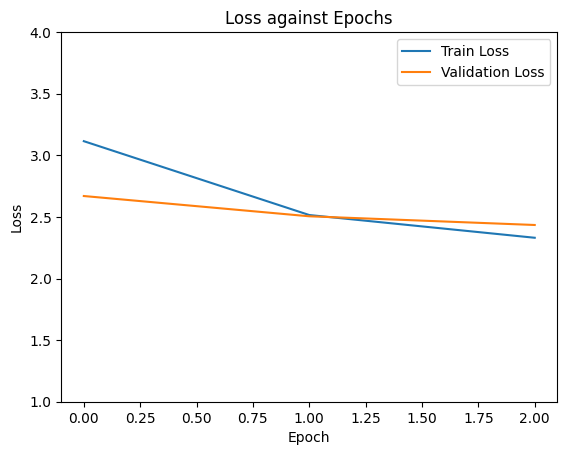

In [25]:
plotTrainLossValLoss(train_loss, val_loss)

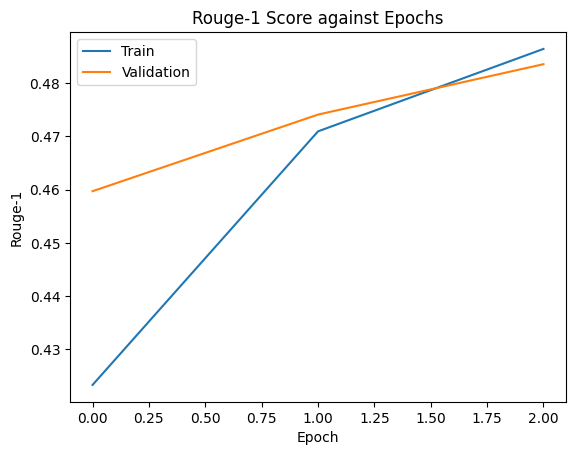

In [26]:
plotTrainRougueValRouge(train_rouge, val_rouge)

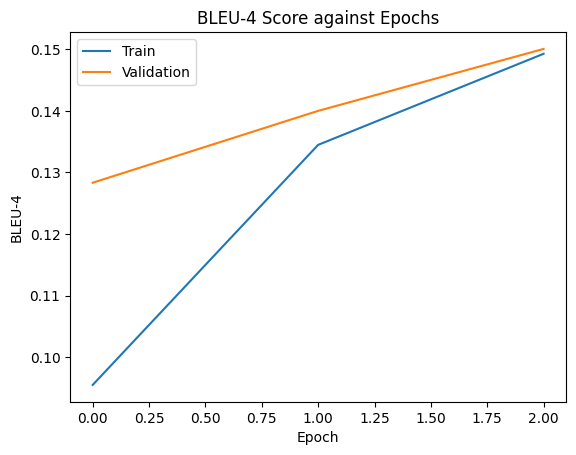

In [27]:
plotTrainBlueValBleu(train_bleu, val_bleu)

### Training With Finetuned MaxVit

In [28]:
class PreTrainedCNNModels(torch.nn.Module):
    def __init__(self, model_type:str, num_unfreeze:int, num_class:int):
        super(PreTrainedCNNModels, self).__init__()
        """
        Class that contains InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit fine tuned models

        Args:
            model_type (str): Determines which pre-trained models to use
                              Must be: InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit
            num_unfreeze (int): Number of layers to unfreeze and finetune
            num_class (int): Number of output classes for the classification
        """
        #selecting model type
        if model_type == 'InceptionV3':
            self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
            self.model.aux_logits = False

        elif model_type == 'Resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        elif model_type == 'Resnet152':
            self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

        elif model_type == 'EfficientNet':
            self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

        elif model_type == 'DenseNet':
            self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        
        elif model_type == 'VGG16':
            self.model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

        elif model_type == 'MaxVit':
            self.model = models.maxvit_t(weights=models.MaxVit_T_Weights.DEFAULT)
        
        else:
            raise Exception("Invalid model type chosen. Please select one of the following\n[InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit]")

        
        #modifying final layer
        if model_type in ['InceptionV3', 'Resnet50', 'Resnet152']:
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_class)

        elif model_type == 'DenseNet':
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_class)

        else:
            self.model.classifier[-1] = torch.nn.Linear(self.model.classifier[-1].in_features, num_class)


        model_paramteres = list(self.model.parameters())
        #unfreeze last num_unfreeze layers
        for param in model_paramteres[-num_unfreeze:]:
            param.requires_grad = True

        #freeze rest of the layers
        for param in model_paramteres[:-num_unfreeze]:
            param.requires_grad = False


    def forward(self, images):
        return self.model(images)

In [30]:
pretrained_model = torch.load('../models/cnn/maxvit_20_best.pt')
model_name = 'TRANSFORMERS_PRETRAINED_11'

In [31]:
# Parameters
num_epochs = 3
learning_rate = 3e-4
embedding_size = 512
num_heads = 8
num_decoder_layers = 4
dropout = 0.10

model = EncoderToDecoder(pretrained_model=pretrained_model,
                          embedding_size=embedding_size,
                          trg_vocab_size=trg_vocab_size,
                          num_heads=num_heads,
                          num_decoder_layers=num_decoder_layers,
                          dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
train_loss, train_bleu, train_rouge, val_loss, val_bleu, val_rouge = train(
    num_epochs=num_epochs, 
    model=model, 
    train_dataloader=train_dataloader_finetune, 
    val_dataloader=val_dataloader_finetune, 
    criterion=criterion, 
    optimizer=optimizer,
    trg_vocab=trg_vocab,
    model_name=model_name
)

[Epoch 0 / 3]
Epoch 1 completed
avg training loss per batch: 3.10151102706094
train bleu score:{'BLEU1': 0.5044290203977624, 'BLEU2': 0.2899355350578084, 'BLEU3': 0.1677243741689968, 'BLEU4': 0.09598166451723833}
train rouge score: {'rouge1': 0.4231994853840103, 'rouge2': 0.1595569837555245, 'rougeL': 0.3965765105209272, 'rougeLsum': 0.39654151898912704}

avg validation loss per batch: 2.6813104496002196
val bleu score: {'BLEU1': 0.5235867679607585, 'BLEU2': 0.3179208795743343, 'BLEU3': 0.19444447147222574, 'BLEU4': 0.1162793667584175}
val rouge score: {'rouge1': 0.4524394915460038, 'rouge2': 0.18767141567940854, 'rougeL': 0.42717020223730606, 'rougeLsum': 0.4271881123716249}
------------------------------------------------------------------
[Epoch 1 / 3]
Epoch 2 completed
avg training loss per batch: 2.5120537524336206
train bleu score:{'BLEU1': 0.5537317721428058, 'BLEU2': 0.3457196599098497, 'BLEU3': 0.2158856764207619, 'BLEU4': 0.13266957637203514}
train rouge score: {'rouge1': 0.4

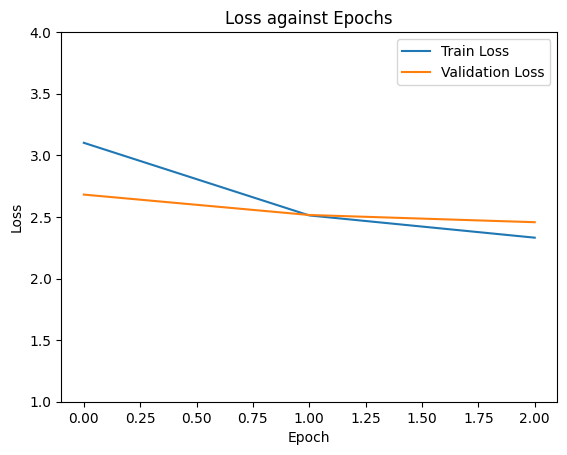

In [33]:
plotTrainLossValLoss(train_loss, val_loss)

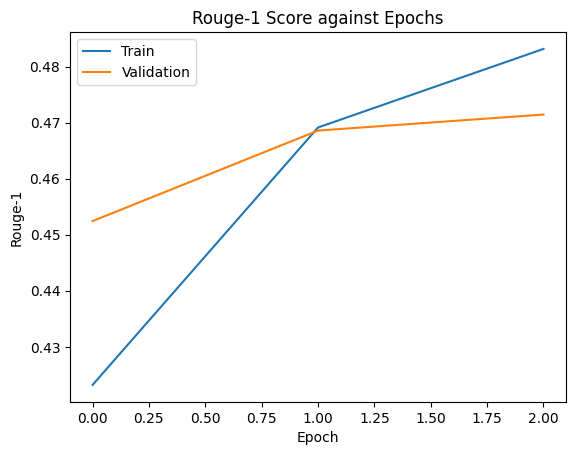

In [34]:
plotTrainRougueValRouge(train_rouge, val_rouge)

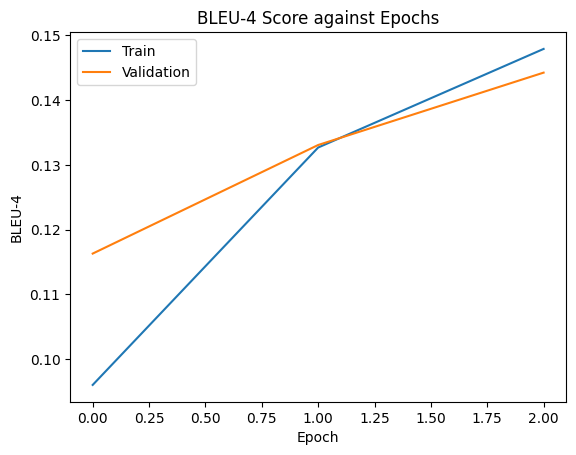

In [35]:
plotTrainBlueValBleu(train_bleu, val_bleu)

# Actual Model Usage

In [36]:
# CLear GPU memory
import gc
torch.cuda.empty_cache()
gc.collect()

8126

In [37]:
torch.backends.cudnn.benchmark = True

test_model_not_finetuned = EncoderToDecoder(pretrained_model=None,
                        embedding_size=embedding_size,
                        trg_vocab_size=trg_vocab_size,
                        num_heads=num_heads,
                        num_decoder_layers=num_decoder_layers,
                        dropout=dropout).to(device)
test_criterion_not_finetuned = torch.nn.CrossEntropyLoss(ignore_index=trg_vocab.stoi["<PAD>"])
test_model_not_finetuned.load_state_dict(load_best_model(version=model_version))

<All keys matched successfully>

In [38]:
test_model_finetuned = EncoderToDecoder(pretrained_model=pretrained_model,
                        embedding_size=embedding_size,
                        trg_vocab_size=trg_vocab_size,
                        num_heads=num_heads,
                        num_decoder_layers=num_decoder_layers,
                        dropout=dropout).to(device)
test_criterion_finetuned = torch.nn.CrossEntropyLoss(ignore_index=trg_vocab.stoi["<PAD>"])
test_model_finetuned.load_state_dict(load_best_model(version=model_name))

<All keys matched successfully>

In [40]:
test_loss, test_bleu, test_rouge = eval(
    model=test_model_finetuned,
    dataloader=test_dataloader_finetune,
    criterion=test_criterion_finetuned,
    vocabulary=test_dataset.vocab
)

print(f"Test Loss: {test_loss}\nTest BLEU:{test_bleu}\nTest Rouge:{test_rouge}")

Test Loss: 2.602361441926753
Test BLEU:{'BLEU1': 0.5457592430556586, 'BLEU2': 0.3385914632854093, 'BLEU3': 0.2067600421437111, 'BLEU4': 0.12242189544310589}
Test Rouge:{'rouge1': 0.45000102294659927, 'rouge2': 0.1860535335863055, 'rougeL': 0.4254706650146627, 'rougeLsum': 0.4255693000570253}


In [48]:
#Assuming mean and std are defined as follows:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

def unnormalize(image:np.array, mean:np.array, std:np.array):
    """
    Function to unnormalize an image given its mean and std
    
    Args: 
        image (np.array): Numpy array of the image
        mean (np.array): Numpy array of the mean 
        std (np.array): Numpy array of the std

    Returns:
        Unnormalised numpy array of the image
    """

    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)    # for inplace operations
    return image



def resize_image(image: torch.Tensor, size: tuple):
    """
    Function to resize image tensor to a specific size
    
    Args:
        image (torch.Tensor): Image tensor
        size (tuple): Desired size of the image (height, width)
        
    Returns:
        Resized image tensor
    """
    return torch.nn.functional.interpolate(image, size=size, mode='nearest')



def multiple_model_captions(model_list, dataloader, vocabulary:Vocabulary, device:str, mean:np.array=np.array([0.485, 0.456, 0.406]), std:np.array=np.array([0.229, 0.224, 0.225]), num_batches:int=1, num_images:int=5, max_length:int=50, show_plot:bool=False):
    """
    Function to generate model predictions for multiple models from the same dataloader

    Arg:
        model_list: list of model to general model prediction (ensure that your model has the function caption_image)
        dataloader: dataset to generate prediction
        vocabulary (Vocabulary): dataset vocabulary
        device (str): cpu or cuda,
        mean (np.array): Numpy array of the mean used for normalisation
        std (np.array): Numpy array of the std used for normalisation
        num_batches (int, optional): how many batches iterating from dataloader, defaults to 1
        num_image (int, optional): how many images per batch to generate model prediction, defaults to 5
        max_length (int, optional): maximum length of generated captions, defaults to 50
        show_plot (bool, optional): show the image and generated captions in a plot, defaults to False
    
    Returns:
        all_predictions (dict): Dictionary containing the dictionary of all generated captions for each model and list of actual captions
    
    """
    for model in model_list:
        model.eval()

    #dictionary containing all the generated predictions and actual predictions
    all_predictions = {'Predicted': {}, 'Possible Captions': []}

    #iterate for num of batches we are testing
    for j in range(num_batches):
        #load images from dataloader
        features, annotations, all_annotations = next(iter(dataloader))
        
        #take first k from batch
        for i in range(num_images):
            image = features[i].unsqueeze(0).to(device)
            all_captions = []

            for idx, model in enumerate(model_list):
                #resize image if its the second model (fintetuned)
                if idx > 0:
                    image = resize_image(image, (224, 224))

                #generate captions from model
                generated_caption, attention = model.caption_image(image, vocabulary, device, max_length=max_length)
                all_captions.append(" ".join(generated_caption[1:-1]))
                
                model_predictions = all_predictions['Predicted'].get(f"model_{idx}", [])
                model_predictions.append(all_captions)
                all_predictions['Predicted'][f"model_{idx}"] = model_predictions

            #plot image and captions
            if show_plot:
                fig, ax = plt.subplots(figsize=(5, 5))
                img = features[i].squeeze()
                img = unnormalize(img, mean, std)  # Unnormalize the image
                img = np.transpose(img.numpy(), (1, 2, 0))
                ax.imshow(img)
                ax.axis('off')

                pred = '\n'.join(all_captions)
                annotation = '\n'.join(all_annotations[i])

                ax.set_title(f'All Model Predictions:\n{pred}\n\nAll Possible Predictions:\n{annotation}', loc='left')

                plt.tight_layout()
                plt.show()

            all_predictions['Possible Captions'].append(all_annotations[i])

    return all_predictions

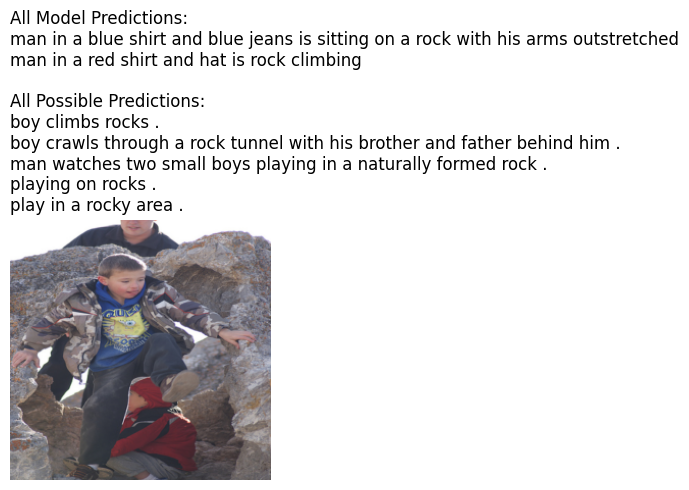

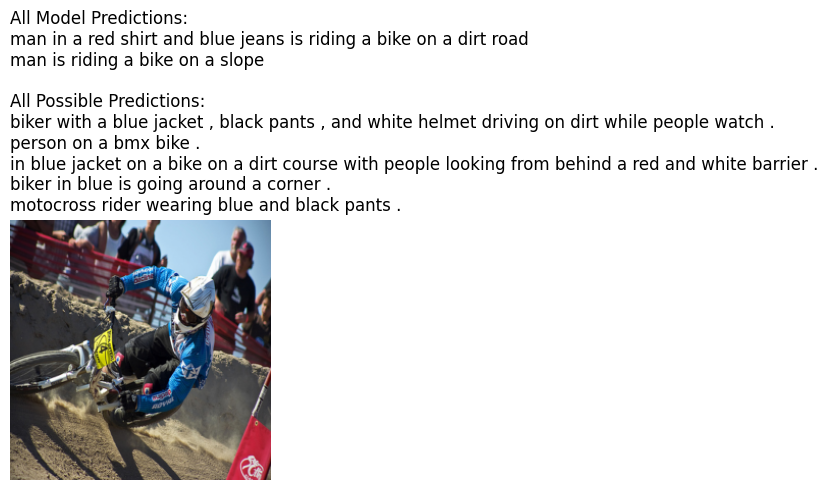

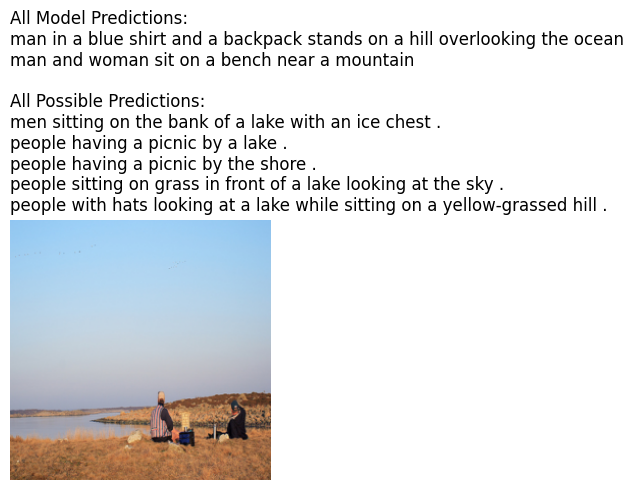

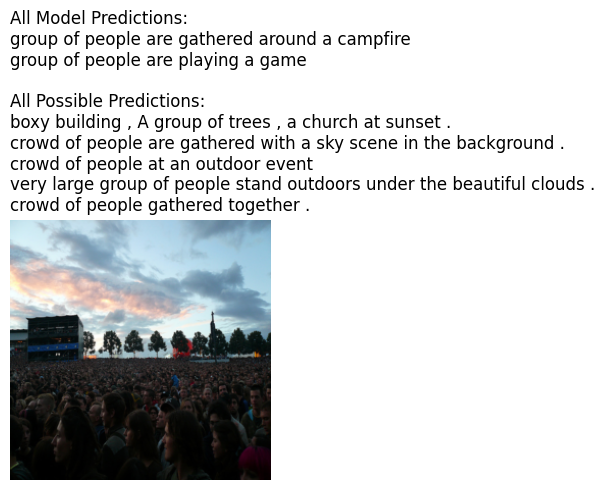

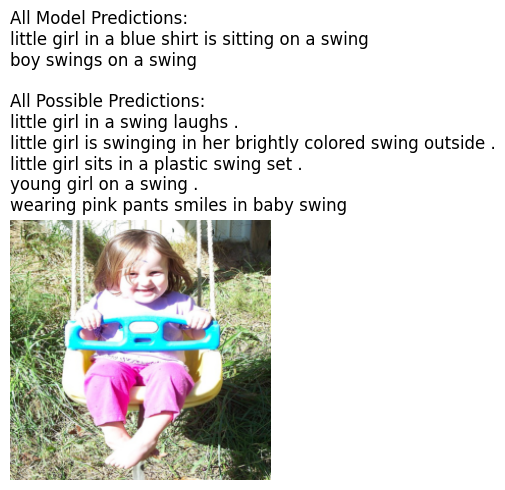

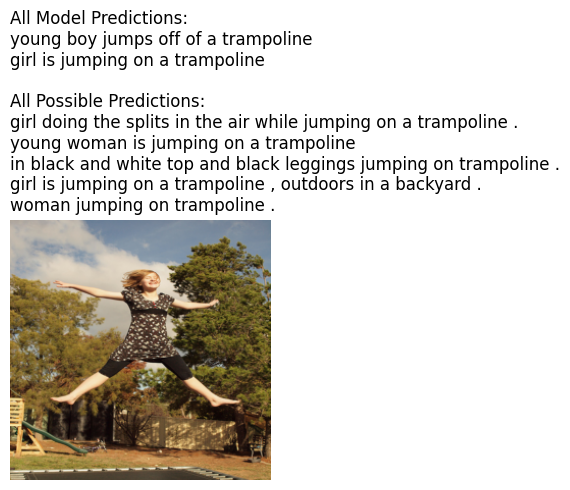

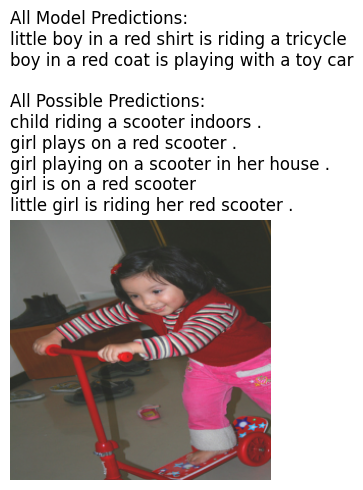

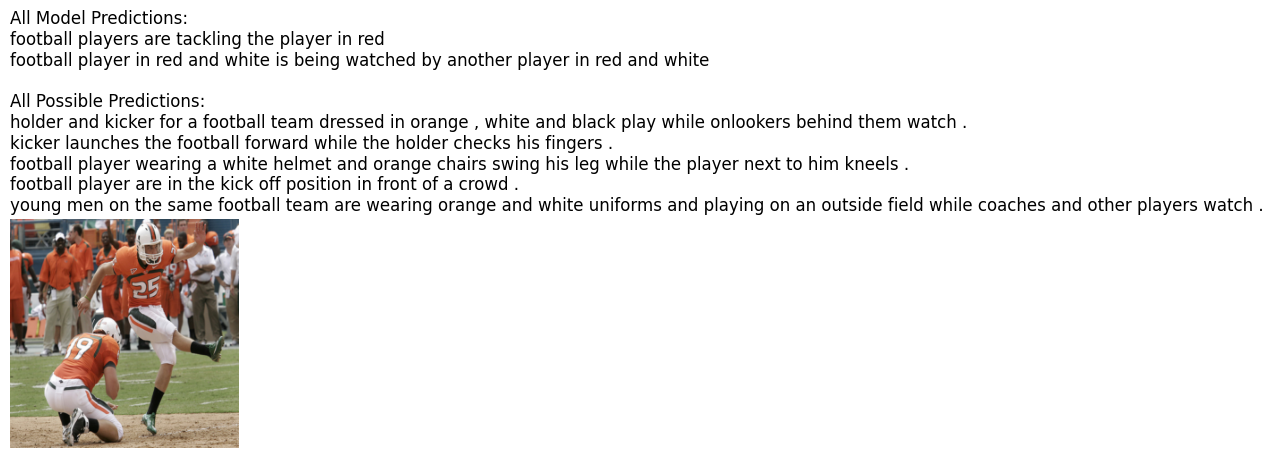

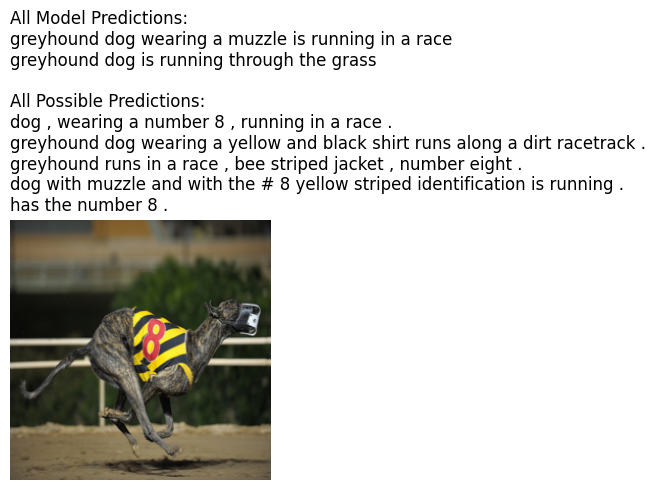

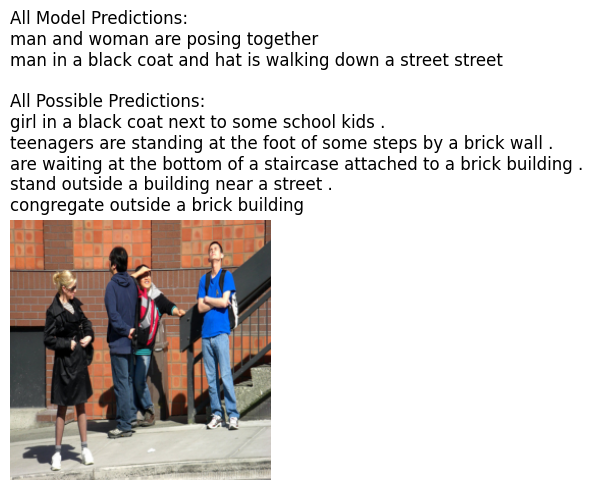

In [50]:
predictions = multiple_model_captions(
    model_list=[test_model_not_finetuned, test_model_finetuned],
    dataloader=test_dataloader,
    vocabulary= test_dataset.vocab,
    device=device,
    mean=mean,
    std=std,
    num_batches=10,
    num_images=1,
    max_length=50,
    show_plot=True
)